<a href="https://colab.research.google.com/github/ScriptsRemote/SCRIPTSREMOTE/blob/main/GEOPRACTICE49_NBR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div>
<img src =https://drive.google.com/uc?id=1MgFIi_U0PH3LVf6qJ9m1KuZ_ywuwKeJ1 width="350px">
<div>

##**Quantificação do Grau de Severidade de Queimada**##

* Autor: Christhian Cunha
* Co-Autor: Gustavo Baptista
<dl>
<dt> Referencias:
<ul>
<li><a href ='http://marte2.sid.inpe.br/col/dpi.inpe.br/marte2/2013/05.28.23.17.32/doc/p0317.pdf'> Teobaldo, D e Baptista, G.M.M - Quantificação do Grau de Severidade de Queimada em Unidades de Conservação no Distrito Federal por meio dos Índices Espectrais dNBR e RdNBR,Anais XVI Simpósio Brasileiro de Sensoriamento Remoto - SBSR, Foz do Iguaçu, PR, Brasil, 13 a 18 de abril de 2013, INPE.]</li>
<dl>

![alt text](https://ruralpecuaria.com.br/painel/img/noticias/3127/noticias_1437078168.jpg)

#<font color=orange> Importando Bibliotecas


In [ ]:
##verificar as bibliotecas
!pip list

In [ ]:
##Instalar as bibliotecas que queremos utilizar
!pip install geemap earthengine-api -q

In [ ]:
##Importar as bibliotecas
import ee
import geemap
import pandas as pd
import matplotlib.pyplot as plt

#<font color=orange> Autenticação do GEE

In [ ]:
##Autenticação do GEE
ee.Authenticate()
ee.Initialize()

#<font color=orange> Visualizando Região de Interesse

In [ ]:
##Definir a roi
roi = ee.Geometry.Point([-47.99209226857971, -15.680991506340531]);
limite = ee.Image().paint(roi.buffer(10000), 0, 2)

In [ ]:
##Definir um map para visualizar
Map = geemap.Map(location=[-15.691568665314366,-47.97286619436096], zoom=12)
##Basemap satélite
Map.setOptions('HYBRID')
##Ponto de interesse
Map.addLayer(limite,{'palette':'red'}, 'ROI')
Map

Map(center=[-15.691568665314366, -47.97286619436096], controls=(ZoomControl(options=['position', 'zoom_in_text…

#<font color=orange> Seleção de imagens

In [ ]:
##Função de data e fator de escala
def date_scale(image):
  #Encerre a função aplicando o fator de escala e inserindo as datas
  return image.divide(10000)\
              .select("B.*")\
              .copyProperties(image, image.propertyNames())\
              .set({'date': image.date().format('YYYY-MM-dd')})

##Função de cálculo do NBR
def addNBR(image):
  nbr = image.normalizedDifference(['B8', 'B12']).rename(['nbr']);
  return image.addBands(nbr).copyProperties(image, image.propertyNames())\


##Minha image collection
collection = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")\
                        .filterBounds(roi)\
                        .filterDate('2022-01-01','2023-02-24')\
                        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',10))\
                        .map(date_scale)\
                        .map(addNBR)

print('Quantas imagens eu tenho',collection.size().getInfo())

Quantas imagens eu tenho 28


In [ ]:
##Verificando a data de nossas imagens
datas = collection.aggregate_array('date')
print('Lista de imagens', datas.getInfo())

Lista de imagens ['2022-03-28', '2022-04-02', '2022-04-07', '2022-04-27', '2022-05-02', '2022-05-22', '2022-06-01', '2022-06-06', '2022-06-16', '2022-06-21', '2022-06-26', '2022-07-01', '2022-07-06', '2022-07-16', '2022-07-21', '2022-07-26', '2022-07-31', '2022-08-05', '2022-08-15', '2022-08-20', '2022-08-25', '2022-08-30', '2022-09-04', '2022-09-09', '2022-10-14', '2022-10-19', '2022-11-13', '2023-01-17']


#<font color=orange> Série temporal NBR

In [ ]:
##Nome
lista_nome = datas.getInfo()
lista_nome

In [ ]:
##vamos transformar nossa coleção em uma pilha de dados
#e extrair estatísticas por região
nbr_tobands = collection.select('nbr').toBands().rename(lista_nome)
nbr_tobands.bandNames().getInfo()

In [ ]:
##Aplicar um reduceRegion
##Usando um Redutor Agrupado
reduce_nbr = nbr_tobands.reduceRegion(**{
##Agrupa os registros do redutor pelo valor de uma determinada entrada e reduz
##cada grupo com o redutor fornecido.
    'reducer': ee.Reducer.mean(),
    'geometry': roi.buffer(10000),
    'scale': 20,
    'bestEffort': True,
    'maxPixels': 1e13
    });

##Obtenha a série temporal de valores como duas listas.
lista_reduce_nbr = reduce_nbr.getInfo()
lista_reduce_nbr

{'2022-03-28': 0.3390163315083878,
 '2022-04-02': 0.3667555053739546,
 '2022-04-07': 0.32487757111799914,
 '2022-04-27': 0.30880860472229466,
 '2022-05-02': 0.31810560362118634,
 '2022-05-22': 0.2691689848379637,
 '2022-06-01': 0.23325008996010138,
 '2022-06-06': 0.20705795712118666,
 '2022-06-16': 0.15741681582611627,
 '2022-06-21': 0.17235316092300454,
 '2022-06-26': 0.15755133246859376,
 '2022-07-01': 0.15564795151451644,
 '2022-07-06': 0.14015563495652356,
 '2022-07-16': 0.11673686358163227,
 '2022-07-21': 0.12420476642267006,
 '2022-07-26': 0.11600150765306202,
 '2022-07-31': 0.11041922793532055,
 '2022-08-05': 0.09283554977184878,
 '2022-08-15': 0.08530744089447756,
 '2022-08-20': 0.11028977342109635,
 '2022-08-25': 0.07488173941982043,
 '2022-08-30': 0.09054112961703879,
 '2022-09-04': 0.07468491479084792,
 '2022-09-09': 0.06271129356784354,
 '2022-10-14': 0.08117418154508024,
 '2022-10-19': 0.08948690152587434,
 '2022-11-13': 0.16441752244360205,
 '2023-01-17': 0.33135816286904

In [ ]:
##criando df
df = pd.DataFrame(lista_reduce_nbr,index=[0])
df = pd.melt(df,var_name='Data',value_name='nbr')
df

,Data,nbr
0,2022-03-28,0.339016
1,2022-04-02,0.366756
2,2022-04-07,0.324878
3,2022-04-27,0.308809
4,2022-05-02,0.318106
5,2022-05-22,0.269169
6,2022-06-01,0.233250
7,2022-06-06,0.207058
8,2022-06-16,0.157417
9,2022-06-21,0.172353


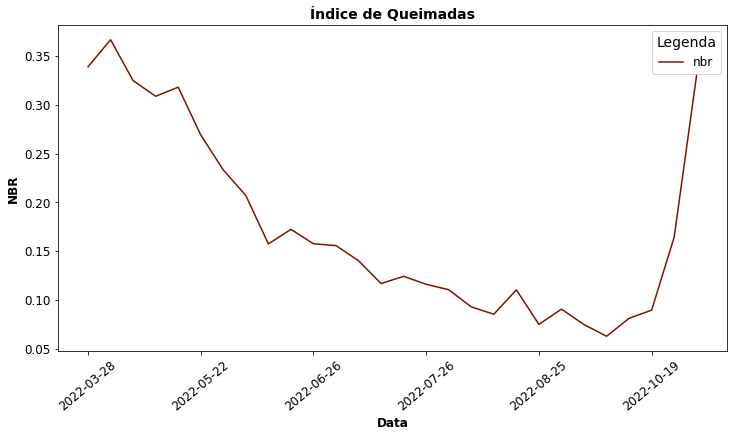

In [ ]:
###Tamanho da figura
fig,ax = plt.subplots(1,1,figsize=(12,6))

##Gráfico de Barras
df.plot.line(x = 'Data',
                    y = ['nbr'],
                    rot = 40,
                    color=['#801100'],
                    ax=ax)

df_index = df[['Data','nbr']]

##Defina o eixo x
plt.xlabel("Data", fontsize=12,fontname="Arial",fontweight='bold')
plt.xticks(fontsize=12)
##Defina o eixo y
plt.ylabel('NBR', fontsize=12,fontname="Arial",fontweight='bold')
plt.yticks(fontsize=12)

##Defina o título
plt.title("Índice de Queimadas", fontsize=14,fontname="Arial", fontweight='bold')
ax.legend(fontsize=12, title='Legenda',title_fontsize=14)

In [ ]:
##Visualizar a imagem
Map = geemap.Map(location=[-15.691568665314366,-47.97286619436096], zoom=12)
##AddLayer
Map.addLayer(collection.filter(ee.Filter.eq('date','2022-04-02')),{'bands':['B4','B8','B2'],'min':0.01, 'max':0.16},'2022-04-02')
Map.addLayer(collection.filter(ee.Filter.eq('date','2022-04-02')),{'bands':['B4','B3','B2'],'min':0.01, 'max':0.16},'True')
Map.addLayer(collection.filter(ee.Filter.eq('date','2022-09-09')),{'bands':['B4','B8','B2'],'min':0.01, 'max':0.16},'2022-09-09')
Map.addLayer(collection.filter(ee.Filter.eq('date','2023-01-17')),{'bands':['B4','B8','B2'],'min':0.01, 'max':0.16},'2023-01-17')
##Adicionar o limite
Map.addLayer(limite,{'palette':'blue'}, 'ROI')
Map

Map(center=[-15.691568665314366, -47.97286619436096], controls=(WidgetControl(options=['position', 'transparen…

#<font color=orange> Cálculo do NBR

<div>
<img src =https://drive.google.com/uc?id=1Bm6sNEZ1DkNI2g8IYkkXHgdHa-7iVBys width="350px">
<div>

In [ ]:
##Aplicar esse índice
# NBR = (B08 - B12) / (B08 + B12)

nbr = collection.filter(ee.Filter.eq('date','2022-09-09')).select('nbr')

##Visualização do resultado
Map = geemap.Map(location=[-15.691568665314366,-47.97286619436096], zoom=12)
Map.addLayer(collection.filter(ee.Filter.eq('date','2022-09-09')),{'bands':['B4','B3','B2'],'min':0.01, 'max':0.16},'True Color')
Map.addLayer(collection.filter(ee.Filter.eq('date','2022-09-09')),{'bands':['B4','B8','B2'],'min':0.01, 'max':0.16},'False Color')
Map.addLayer(nbr, {'palette':['red','orange','yellow','green','darkgreen'],'min':-0.5665, 'max':0.3243}, 'NBR')

##Definindo limite
limite = ee.Image().paint(roi.buffer(10000), 0, 2)
Map.addLayer(limite,{},'ROI')
Map

Map(center=[-15.691568665314366, -47.97286619436096], controls=(WidgetControl(options=['position', 'transparen…

#<font color=orange> Cálculo do dNBR


<div>
<img src =https://drive.google.com/uc?id=1jaj6NikBBOoez5g_R-5BOXTUihNxLvgc width="350px">
<div>

In [ ]:
#Datas importantes
data_pos_fogo = '2022-09-09'
data_pre_fogo = '2022-04-02'
data_rebrota = '2023-01-17'

In [ ]:
##Definindo imagens pré e pós
pre_fogo = collection.filter(ee.Filter.eq('date',data_pre_fogo))
pos_fogo = collection.filter(ee.Filter.eq('date',data_pos_fogo))

##Selecionando somente a banda NBR
beforeNbr = pre_fogo.select('nbr').mean();
afterNbr = pos_fogo.select('nbr').mean();

## Cáculo do dNBR
dNBR = beforeNbr.subtract(afterNbr).rename('dNBR')

In [ ]:
##Visualização do resultado
Map = geemap.Map(location=[-15.691568665314366,-47.97286619436096], zoom=12)
Map.addLayer(pre_fogo,{'bands':['B4','B3','B2'],'min':0.019, 'max':0.19},'Pré Fogo')
Map.addLayer(pos_fogo,{'bands':['B4','B3','B2'],'min':0.019, 'max':0.19},'Pós Fogo')
Map.addLayer(dNBR, {'palette':['darkgreen','green','yellow','orange','red'],'min':0.1, 'max':0.7}, 'dNBR')

##Definindo limite
limite = ee.Image().paint(roi.buffer(10000), 0, 2)
Map.addLayer(limite,{},'ROI')
Map

Map(center=[-15.691568665314366, -47.97286619436096], controls=(WidgetControl(options=['position', 'transparen…

#<font color=orange> Cálculo do Índice relativo diferenciado de queimada por razão normalizada - RdNBR


<div>
<img src =https://drive.google.com/uc?id=15oKh3jrFNlnILaSXkU2aSasR5sGEoWUN width="350px">
<div>

In [ ]:
##Definição da expressão para o cálculo do RdNBR
RdNBR = (dNBR.divide((beforeNbr.abs()).sqrt())).rename('RdNBR')

# RdNBR = first_img.expression(
            #  '(dNBR/sqrt(abs(NBRpre)))', {'dNBR':dNBR , 'NBRpre':beforeNbr}).rename('RdNBR')

In [ ]:
##Visualização do resultado
Map = geemap.Map(location=[-15.691568665314366,-47.97286619436096], zoom=12)
Map.addLayer(pre_fogo,{'bands':['B4','B3','B2'],'min':0.019, 'max':0.19},'Pré Fogo')
Map.addLayer(pos_fogo,{'bands':['B4','B3','B2'],'min':0.019, 'max':0.19},'Pós Fogo')
Map.addLayer(RdNBR, {'palette':['darkgreen','green','yellow','orange','red'],'min':0.1, 'max':0.7}, 'RdNBR')

##Definindo limite
limite = ee.Image().paint(roi.buffer(10000), 0, 2)
Map.addLayer(limite,{},'ROI')
Map

Map(center=[-15.691568665314366, -47.97286619436096], controls=(WidgetControl(options=['position', 'transparen…

#<font color=orange> Reclassificação Cálculo do Índice relativo diferenciado de queimada por razão normalizada - RdNBR


<div>
<img src =https://www.un-spider.org/sites/default/files/table+legend.PNG width="350px">
<div>

In [ ]:
##Reclassificando imagem
severity_dNBR = dNBR.where(dNBR.lt(0.10), 0)\
  .where(dNBR.gte(0.10).And(dNBR.lt(0.27)), 1)\
  .where(dNBR.gte(0.27).And(dNBR.lt(0.44)), 2)\
  .where(dNBR.gte(0.44).And(dNBR.lt(0.66)), 3)\
  .where(dNBR.gt(0.66), 4)
##Reclassificando imagem
severity_RdNBR = RdNBR.where(RdNBR.lt(0.10), 0)\
  .where(RdNBR.gte(0.10).And(RdNBR.lt(0.27)), 1)\
  .where(RdNBR.gte(0.27).And(RdNBR.lt(0.44)), 2)\
  .where(RdNBR.gte(0.44).And(RdNBR.lt(0.66)), 3)\
  .where(RdNBR.gt(0.66), 4)

In [ ]:
##Visualização do resultado
Map = geemap.Map(location=[-15.691568665314366,-47.97286619436096], zoom=12)

##paleta de cores
# | Gravidade | Classe | Cor |
# |--------------|-------|---------|
# | Não queimado | 0 | verde |
# | Gravidade baixa | 1 | amarelo |
# | Moderado-Baixo | 2 | organge |
# | Moderado-Alto| 3 | vermelho |
# | alta | 4 | magenta |


palette = ['green','yellow', 'orange', 'red', 'magenta'];
Map.addLayer(pos_fogo,{'bands':['B4','B3','B2'],'min':0.019, 'max':0.19},'Pós Fogo')
Map.addLayer(severity_dNBR, {'min':0, 'max':4, 'palette': palette}, 'dNBR Severidade');
Map.addLayer(severity_RdNBR, {'palette':palette,'min':0, 'max':4}, 'RdNBR Severidade')

##Definindo limite
limite = ee.Image().paint(roi.buffer(10000), 0, 2)
Map.addLayer(limite,{},'ROI')
Map

Map(center=[-15.691568665314366, -47.97286619436096], controls=(WidgetControl(options=['position', 'transparen…

#<font color=orange> Análise estatística



In [ ]:
##Bands
print(severity_RdNBR.bandNames().getInfo())
print(severity_dNBR.bandNames().getInfo())

['RdNBR']
['dNBR']


In [ ]:
##Cálculo de área
areaImage = ee.Image.pixelArea().divide(1e6).addBands(severity_RdNBR);

##Calculo de área por classe
##Usando um Redutor Agrupado
areas = areaImage.reduceRegion(**{
##Agrupa os registros do redutor pelo valor de uma determinada entrada e reduz
##cada grupo com o redutor fornecido.
      'reducer': ee.Reducer.sum().group(**{
      'groupField': 1,
      'groupName': 'RdNBR',
    }),
    'geometry': roi.buffer(10000),
    'scale': 20,
    'bestEffort': True,
    'maxPixels': 1e13
    });


##Obtenha a série temporal de valores como duas listas.
lista = areas.get('groups').getInfo()
lista

[{'RdNBR': 0, 'sum': 20.293970918267533},
 {'RdNBR': 1, 'sum': 21.943594055518727},
 {'RdNBR': 2, 'sum': 77.87047815725444},
 {'RdNBR': 3, 'sum': 115.1089950411512},
 {'RdNBR': 4, 'sum': 74.10252428709732}]

In [ ]:
##Definir uma legenda
legenda= ['Não queimado','Severidade baixa','Moderado-Baixo','Moderado-Alto','Alta']

In [ ]:
##Conveter a área para um Dataframe
area_df = pd.DataFrame(lista, columns=['RdNBR','sum']).rename(columns={'sum':'Área RdNBR'})
area_df['legenda']=legenda
area_df.round(2)

,RdNBR,Área RdNBR,legenda
0,0,20.29,Não queimado
1,1,21.94,Severidade baixa
2,2,77.87,Moderado-Baixo
3,3,115.11,Moderado-Alto
4,4,74.10,Alta


In [ ]:
##Cálculo de área
areaImage_dNBR = ee.Image.pixelArea().divide(1e6).addBands(severity_dNBR);

##Calculo de área por classe
##Usando um Redutor Agrupado
areas_dNBR = areaImage_dNBR.reduceRegion(**{
##Agrupa os registros do redutor pelo valor de uma determinada entrada e reduz
##cada grupo com o redutor fornecido.
      'reducer': ee.Reducer.sum().group(**{
      'groupField': 1,
      'groupName': 'dNBR',
    }),
    'geometry': roi.buffer(10000),
    'scale': 20,
    'bestEffort': True,
    'maxPixels': 1e13
    });


##Obtenha a série temporal de valores como duas listas.
lista_dNBR = areas_dNBR.get('groups').getInfo()
lista_dNBR

[{'dNBR': 0, 'sum': 30.005678295683445},
 {'dNBR': 1, 'sum': 92.97587062903155},
 {'dNBR': 2, 'sum': 139.20276174447514},
 {'dNBR': 3, 'sum': 35.60667447153712},
 {'dNBR': 4, 'sum': 11.528577318573625}]

In [ ]:
##Conveter a área para um Dataframe
area_df_dNBR = pd.DataFrame(lista_dNBR, columns=['dNBR','sum']).rename(columns={'sum':'Área dNBR'})
area_df_dNBR['legenda']=legenda
area_df_dNBR.round(2)

,dNBR,Área dNBR,legenda
0,0,30.01,Não queimado
1,1,92.98,Severidade baixa
2,2,139.20,Moderado-Baixo
3,3,35.61,Moderado-Alto
4,4,11.53,Alta


In [ ]:
##Juntando as bases
df_indices = area_df_dNBR.merge(area_df)
df_indices

,dNBR,Área dNBR,legenda,RdNBR,Área RdNBR
0,0,30.005678,Não queimado,0,20.293971
1,1,92.975871,Severidade baixa,1,21.943594
2,2,139.202762,Moderado-Baixo,2,77.870478
3,3,35.606674,Moderado-Alto,3,115.108995
4,4,11.528577,Alta,4,74.102524


#<font color=orange> Análise Gráfica

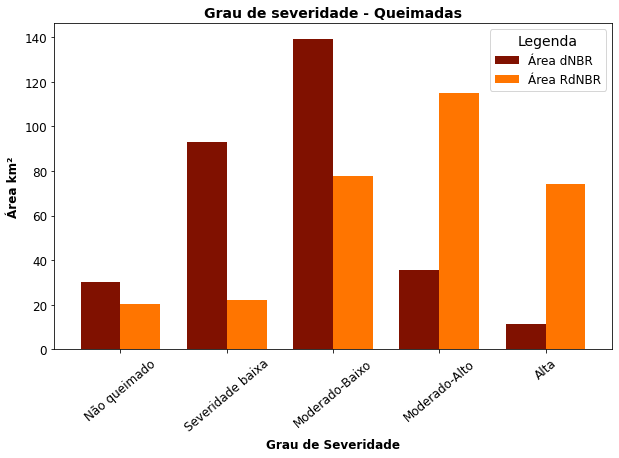

In [ ]:
###Tamanho da figura
fig,ax = plt.subplots(1,1,figsize=(10,6))

##Gráfico de Barras
df_indices.plot.bar(x = 'legenda',
                    y = ['Área dNBR', 'Área RdNBR'],
                    rot = 40,
                    color=['#801100','#ff7500'],
                    width=0.75,
                    ax=ax)

df_index = df_indices[['legenda','Área RdNBR']]

##Defina o eixo x
plt.xlabel("Grau de Severidade", fontsize=12,fontname="Arial",fontweight='bold')
plt.xticks(fontsize=12)
##Defina o eixo y
plt.ylabel('Área km²', fontsize=12,fontname="Arial",fontweight='bold')
plt.yticks(fontsize=12)

##Defina o título
plt.title("Grau de severidade - Queimadas", fontsize=14,fontname="Arial", fontweight='bold')
ax.legend(fontsize=12, title='Legenda',title_fontsize=14)

#<font color=orange> Análise de Rebrota

#<font color=orange> Cálculo do dNBR Rebrota


<div>
<img src =https://drive.google.com/uc?id=1jaj6NikBBOoez5g_R-5BOXTUihNxLvgc width="350px">
<div>

In [ ]:
#Datas importantes
data_pos_fogo = '2022-09-09'
data_pre_fogo = '2022-04-02'
data_rebrota = '2023-01-17'

In [ ]:
##Definindo imagens pré e pós
pos_fogo = collection.filter(ee.Filter.eq('date',data_pos_fogo))
rebrota = collection.filter(ee.Filter.eq('date',data_rebrota))

##Selecionando somente a banda NBR
beforeNbr = pos_fogo.select('nbr').mean();
afterNbr = rebrota.select('nbr').mean();

## Cáculo do dNBR
dNBR_rebrota = beforeNbr.subtract(afterNbr).rename('dNBR')

In [ ]:
##Visualização do resultado
Map = geemap.Map(location=[-15.691568665314366,-47.97286619436096], zoom=12)
Map.addLayer(pos_fogo,{'bands':['B4','B3','B2'],'min':0.019, 'max':0.19},'Pós Fogo')
Map.addLayer(rebrota,{'bands':['B4','B3','B2'],'min':0.019, 'max':0.19},'Rebrota')
Map.addLayer(dNBR_rebrota, {'palette':['darkgreen','green','yellow','orange','red'],'min':0.1, 'max':0.7}, 'dNBR Rebrota')

##Definindo limite
limite = ee.Image().paint(roi.buffer(10000), 0, 2)
Map.addLayer(limite,{},'ROI')
Map

Map(center=[-15.691568665314366, -47.97286619436096], controls=(WidgetControl(options=['position', 'transparen…

#<font color=orange> Cálculo do Índice relativo diferenciado de queimada por razão normalizada - RdNBR Rebrota


<div>
<img src =https://drive.google.com/uc?id=15oKh3jrFNlnILaSXkU2aSasR5sGEoWUN width="350px">
<div>

In [ ]:
##Definição da expressão para o cálculo do RdNBR
RdNBR_rebrota = (dNBR_rebrota.divide((beforeNbr.abs()).sqrt())).rename('RdNBR')

# RdNBR = first_img.expression(
            #  '(dNBR/sqrt(abs(NBRpre)))', {'dNBR':dNBR , 'NBRpre':beforeNbr}).rename('RdNBR')

In [ ]:
##Visualização do resultado
Map = geemap.Map(location=[-15.691568665314366,-47.97286619436096], zoom=12)
Map.addLayer(pos_fogo,{'bands':['B4','B3','B2'],'min':0.019, 'max':0.19},'Pós Fogo')
Map.addLayer(rebrota,{'bands':['B4','B3','B2'],'min':0.019, 'max':0.19},'Rebrota')
Map.addLayer(RdNBR_rebrota, {'palette':['darkgreen','green','yellow','orange','red'],'min':0.1, 'max':0.7}, 'RdNBR Rebrota')

##Definindo limite
limite = ee.Image().paint(roi.buffer(10000), 0, 2)
Map.addLayer(limite,{},'ROI')
Map

Map(center=[-15.691568665314366, -47.97286619436096], controls=(WidgetControl(options=['position', 'transparen…

#<font color=orange> Reclassificação Cálculo do Índice relativo diferenciado de queimada por razão normalizada - RdNBR Rebrota


<div>
<img src =https://www.un-spider.org/sites/default/files/table+legend.PNG width="350px">
<div>

In [ ]:
##Reclassificando imagem
severity_dNBR_rebrota = dNBR_rebrota.where(dNBR_rebrota.lt(0.10), 0)\
  .where(dNBR_rebrota.gte(0.10).And(dNBR_rebrota.lt(0.27)), 1)\
  .where(dNBR_rebrota.gte(0.27).And(dNBR_rebrota.lt(0.44)), 2)\
  .where(dNBR_rebrota.gte(0.44).And(dNBR_rebrota.lt(0.66)), 3)\
  .where(dNBR_rebrota.gt(0.66), 4)
##Reclassificando imagem
severity_RdNBR_rebrota = RdNBR_rebrota.where(RdNBR_rebrota.lt(0.10), 0)\
  .where(RdNBR_rebrota.gte(0.10).And(RdNBR_rebrota.lt(0.27)), 1)\
  .where(RdNBR_rebrota.gte(0.27).And(RdNBR_rebrota.lt(0.44)), 2)\
  .where(RdNBR_rebrota.gte(0.44).And(RdNBR_rebrota.lt(0.66)), 3)\
  .where(RdNBR_rebrota.gt(0.66), 4)

In [ ]:
##Visualização do resultado
Map = geemap.Map(location=[-15.691568665314366,-47.97286619436096], zoom=12)

##paleta de cores
# | Gravidade | Classe | Cor |
# |--------------|-------|---------|
# | Não queimado | 0 | verde |
# | Gravidade baixa | 1 | amarelo |
# | Moderado-Baixo | 2 | organge |
# | Moderado-Alto| 3 | vermelho |
# | alta | 4 | magenta |


palette = ['green','yellow', 'orange', 'red', 'magenta'];
Map.addLayer(pos_fogo,{'bands':['B4','B3','B2'],'min':0.019, 'max':0.19},'Pós Fogo')
Map.addLayer(severity_dNBR_rebrota, {'min':0, 'max':4, 'palette': palette}, 'dNBR Severidade Rebrota');
Map.addLayer(severity_RdNBR_rebrota, {'palette':palette,'min':0, 'max':4}, 'RdNBR Severidade Rebrota')

##Definindo limite
limite = ee.Image().paint(roi.buffer(10000), 0, 2)
Map.addLayer(limite,{},'ROI')
Map

Map(center=[-15.691568665314366, -47.97286619436096], controls=(WidgetControl(options=['position', 'transparen…

#<font color=orange> Análise estatística



In [ ]:
##Bands
print(severity_RdNBR_rebrota.bandNames().getInfo())
print(severity_dNBR_rebrota.bandNames().getInfo())

['RdNBR']
['dNBR']


In [ ]:
##Cálculo de área
areaImage = ee.Image.pixelArea().divide(1e6).addBands(severity_RdNBR_rebrota);

##Calculo de área por classe
##Usando um Redutor Agrupado
areas = areaImage.reduceRegion(**{
##Agrupa os registros do redutor pelo valor de uma determinada entrada e reduz
##cada grupo com o redutor fornecido.
      'reducer': ee.Reducer.sum().group(**{
      'groupField': 1,
      'groupName': 'RdNBR',
    }),
    'geometry': roi.buffer(10000),
    'scale': 20,
    'bestEffort': True,
    'maxPixels': 1e13
    });


##Obtenha a série temporal de valores como duas listas.
lista = areas.get('groups').getInfo()
lista

[{'RdNBR': 0, 'sum': 295.57668398261035},
 {'RdNBR': 1, 'sum': 6.039267720566726},
 {'RdNBR': 2, 'sum': 2.8560402066213157},
 {'RdNBR': 3, 'sum': 1.9388097223154959},
 {'RdNBR': 4, 'sum': 2.9087608270891043}]

In [ ]:
##Definir uma legenda
legenda= ['Não queimado','Gravidade baixa','Moderado-Baixo','Moderado-Alto','Alta']

In [ ]:
##Conveter a área para um Dataframe
area_df = pd.DataFrame(lista, columns=['RdNBR','sum']).rename(columns={'sum':'Área RdNBR'})
area_df['legenda']=legenda
area_df.round(2)

,RdNBR,Área RdNBR,legenda
0,0,295.58,Não queimado
1,1,6.04,Gravidade baixa
2,2,2.86,Moderado-Baixo
3,3,1.94,Moderado-Alto
4,4,2.91,Alta


In [ ]:
##Cálculo de área
areaImage_dNBR = ee.Image.pixelArea().divide(1e6).addBands(severity_dNBR_rebrota);

##Calculo de área por classe
##Usando um Redutor Agrupado
areas_dNBR = areaImage_dNBR.reduceRegion(**{
##Agrupa os registros do redutor pelo valor de uma determinada entrada e reduz
##cada grupo com o redutor fornecido.
      'reducer': ee.Reducer.sum().group(**{
      'groupField': 1,
      'groupName': 'dNBR',
    }),
    'geometry': roi.buffer(10000),
    'scale': 20,
    'bestEffort': True,
    'maxPixels': 1e13
    });


##Obtenha a série temporal de valores como duas listas.
lista_dNBR = areas_dNBR.get('groups').getInfo()
lista_dNBR

[{'dNBR': 0, 'sum': 300.67008503827134},
 {'dNBR': 1, 'sum': 5.368494550863306},
 {'dNBR': 2, 'sum': 1.7949204593172126},
 {'dNBR': 3, 'sum': 1.1578408773513351},
 {'dNBR': 4, 'sum': 0.32822153341674715}]

In [ ]:
##Conveter a área para um Dataframe
area_df_dNBR = pd.DataFrame(lista_dNBR, columns=['dNBR','sum']).rename(columns={'sum':'Área dNBR'})
area_df_dNBR['legenda']=legenda
area_df_dNBR.round(2)

,dNBR,Área dNBR,legenda
0,0,300.67,Não queimado
1,1,5.37,Gravidade baixa
2,2,1.79,Moderado-Baixo
3,3,1.16,Moderado-Alto
4,4,0.33,Alta


In [ ]:
##Juntando as bases
df_indices = area_df_dNBR.merge(area_df)
df_indices.round(2)

,dNBR,Área dNBR,legenda,RdNBR,Área RdNBR
0,0,300.67,Não queimado,0,295.58
1,1,5.37,Gravidade baixa,1,6.04
2,2,1.79,Moderado-Baixo,2,2.86
3,3,1.16,Moderado-Alto,3,1.94
4,4,0.33,Alta,4,2.91


#<font color=orange> Análise Gráfica

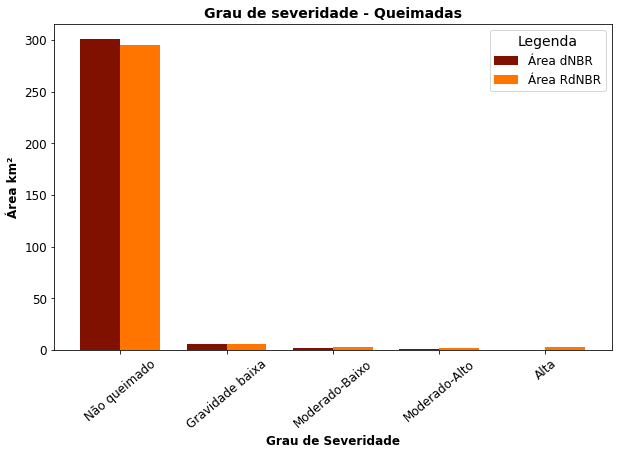

In [ ]:
###Tamanho da figura
fig,ax = plt.subplots(1,1,figsize=(10,6))

##Gráfico de Barras
df_indices.plot.bar(x = 'legenda',
                    y = ['Área dNBR', 'Área RdNBR'],
                    rot = 40,
                    color=['#801100','#ff7500'],
                    width=0.75,
                    ax=ax)

df_index = df_indices[['legenda','Área RdNBR']]

##Defina o eixo x
plt.xlabel("Grau de Severidade", fontsize=12,fontname="Arial",fontweight='bold')
plt.xticks(fontsize=12)
##Defina o eixo y
plt.ylabel('Área km²', fontsize=12,fontname="Arial",fontweight='bold')
plt.yticks(fontsize=12)

##Defina o título
plt.title("Grau de severidade - Queimadas", fontsize=14,fontname="Arial", fontweight='bold')
ax.legend(fontsize=12, title='Legenda',title_fontsize=14)